# Puppies vs. Old Dogs Classifier

Creating my own dataset from Google Images. First I will get a list of URLs using a little bit of Java code:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Then upload the downloaded images into the GCP Jupyter Notebook. 
* Note: The first few cells of code after the import statement aren't run top-bottom -> They are run like Jeremy describes in: https://course.fast.ai/videos/?lesson=2 (time = 20:00)

In [1]:
from fastai.vision import *

In [2]:
path = Path('data2')

In [3]:
file = 'puppy2.csv'
folder = 'puppy'

In [6]:
file = 'dog2.csv'
folder = 'dogs'

In [7]:
# Run this cell once for puppies, and once for dogs
# need to manually upload csv files into data/dogs directory
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(path/file, dest, max_pics=500)

In [8]:
# remove any images we can't open
verify_images(dest, delete=True, max_size=500)

In [9]:
classes = ['puppy', 'dog'] # two labels

In [10]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

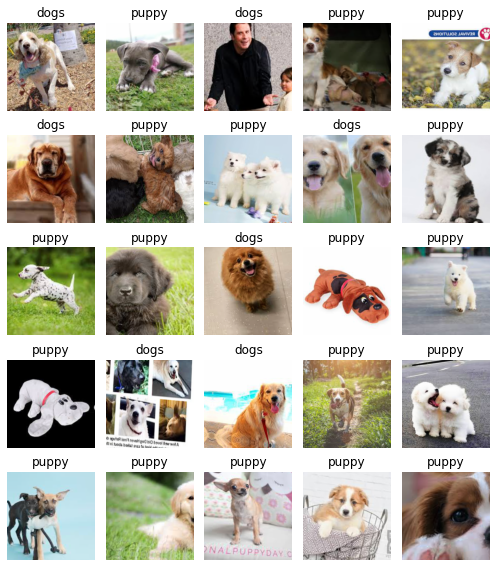

In [11]:
data.show_batch(rows=5, figsize=(7,8))

In [21]:
# label names, number classes, number training data, number validation data
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['dogs', 'puppy'], 2, 580, 145)

## Train the Model

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [23]:
learn.fit_one_cycle(3)
# also my error rate is fairly high
# 17.9% error rate so far
# model slightly undertrained

epoch,train_loss,valid_loss,error_rate,time
0,0.978773,0.626566,0.241379,00:07
1,0.732133,0.582807,0.200000,00:06
2,0.574116,0.549178,0.179310,00:06


In [24]:
learn.save('res34-stage1')

### Tweak by Adjusting Learning Rate

* Our validation loss is lower than our training loss. The model is undertrained, and could use from some more epochs. 

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


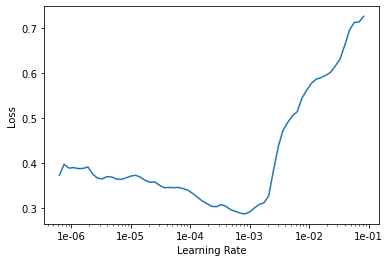

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2,max_lr=slice(1e-5,1e-4))    # 17.9% error rate now
# model looks trained about right
# now try cleaning data to get a better result

epoch,train_loss,valid_loss,error_rate,time
0,0.422335,0.593444,0.186207,00:07
1,0.353934,0.593304,0.179310,00:07


In [29]:
learn.save('res34-stage2')

## Data Cleaning
So we're down to a 22.8% error. Now we are going to try to clean our training data a bit to get a better result.

In [30]:
learn.load('res34-stage2')
interp = ClassificationInterpretation.from_learner(learn)

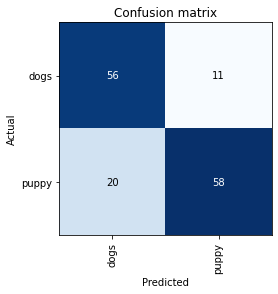

In [27]:
interp.plot_confusion_matrix()    # many real puppies were predicted as dogs

In [31]:
from fastai.widgets import *
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

ds, idxs = DatasetFormatter().from_toplosses(learn)

In [32]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now recreate the model with the cleaned data

In [33]:
np.random.seed(42)
cleaned_data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [34]:
cl_learn = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [35]:
cl_learn.fit_one_cycle(3)    # retraining with the cleaned dataset    
# 21.3% error rate now, well trained but much higher error rate (am I deleting unnecessary images??)

epoch,train_loss,valid_loss,error_rate,time
0,1.037026,1.023381,0.255172,00:06
1,0.785589,0.698010,0.213793,00:06
2,0.622657,0.706253,0.213793,00:06


In [36]:
cl_learn.save('cl_res34-stage1')

In [37]:
cl_learn.unfreeze()

In [38]:
cl_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


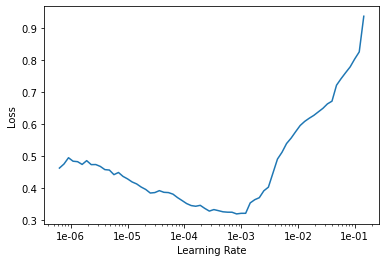

In [39]:
cl_learn.recorder.plot()

In [40]:
cl_learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))    # had a 16.5% error rate, getting better

epoch,train_loss,valid_loss,error_rate,time
0,0.384181,0.631983,0.179310,00:07
1,0.308309,0.617885,0.165517,00:06


In [41]:
cl_learn.save('cl_res34-stage2')

## Resnet 50
Our final stage with the cleaned data gives us a 16.5% error rate. I am now going to try res-50, and see how much room for improvement there is. The goal will be to not overtrain the model and get an error rate around 15% or lower.

In [42]:
learn50 = cnn_learner(cleaned_data, models.resnet50, metrics=error_rate)

In [43]:
learn50.fit_one_cycle(8)    # 18.6% error rate, this is possibly getting over trained

epoch,train_loss,valid_loss,error_rate,time
0,1.064833,0.843451,0.275862,00:09
1,0.787379,0.993466,0.179310,00:08
2,0.646342,1.207012,0.193103,00:08
3,0.535020,0.920614,0.193103,00:08
4,0.445449,0.814871,0.172414,00:08
5,0.381359,0.786792,0.193103,00:08
6,0.336331,0.766704,0.186207,00:08
7,0.298031,0.757721,0.186207,00:08


In [44]:
learn50.save('clean50-stage1')

In [45]:
learn50.unfreeze()

In [46]:
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


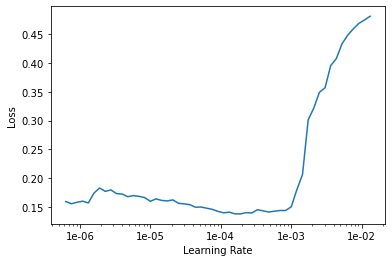

In [47]:
learn50.recorder.plot()

In [48]:
learn50.fit_one_cycle(2,max_lr=slice(5e-6,1e-4))    # 17.2% error, t-loss<<<v-loss

epoch,train_loss,valid_loss,error_rate,time
0,0.126381,0.701175,0.186207,00:09
1,0.145200,0.681430,0.172414,00:09


In [49]:
learn50.save('clean50-stage2')

Try training resnet-50 on the uncleaned/original data

In [50]:
learn50_dirty = cnn_learner(data, models.resnet50, metrics=error_rate)

In [51]:
learn50_dirty.fit_one_cycle(7)    # 15.8% error

epoch,train_loss,valid_loss,error_rate,time
0,1.022129,0.827383,0.227586,00:07
1,0.861033,1.095379,0.255172,00:08
2,0.714593,0.740635,0.179310,00:08
3,0.575818,0.683434,0.186207,00:08
4,0.474576,0.637077,0.172414,00:07
5,0.398776,0.610656,0.172414,00:08
6,0.337346,0.602938,0.158621,00:08


In [53]:
learn50_dirty.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


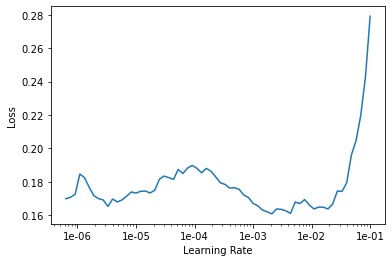

In [55]:
learn50_dirty.recorder.plot()

In [56]:
learn50_dirty.fit_one_cycle(3,max_lr=slice(3e-4,1e-3))    # 15.8% error, pretty decently trained (overtrained??)
#v-loss >>> t-loss

epoch,train_loss,valid_loss,error_rate,time
0,0.180665,0.568555,0.172414,00:08
1,0.157843,0.592525,0.165517,00:08
2,0.144132,0.586680,0.158621,00:08


In [57]:
learn50_dirty.save('res50-uncl-final')

In [58]:
learn50_dirty.export('dog50-final')